# Test of het mogelijk is toch een klein modelletje te trainen


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal


df = pd.read_csv('./grouped.csv')
df.head(5)


,user_id,total_sessions,ratio_finished,std_step_time,ratio_mistakes,goal_mistakes_ratio,goal_finished_ratio,goal_avg_step_time,list_mistakes_ratio,list_finished_ratio,list_avg_step_time,learn_mistakes_ratio,learn_finished_ratio,learn_avg_step_time,check_mistakes_ratio,check_finished_ratio,check_avg_step_time
0,1,4,0.500000,2.146225,0.250000,0.0,1.0,2.564422,0.0,0.0,2.381600,NaN,0.750000,1.395233,NaN,0.0,NaN
1,2,3,0.666667,0.088567,0.288675,0.0,1.0,0.325139,0.0,0.0,0.198094,NaN,1.000000,0.543699,NaN,0.0,NaN
2,3,2,1.000000,0.243716,0.000000,0.0,1.0,0.194454,0.0,0.0,0.090510,NaN,1.000000,0.866206,NaN,0.0,NaN
3,4,3,0.333333,1.394298,0.000000,0.0,1.0,1.043377,0.0,0.0,1.765962,NaN,0.333333,NaN,NaN,0.0,NaN
4,5,8,0.625000,2.898814,0.267261,0.0,1.0,3.148489,0.0,0.0,2.768072,NaN,0.875000,3.027969,NaN,0.0,0.784889


# Feature engineering
Reduceren van het aantal variabelen, en hiermee onevenwichtige schaalverdelingen tegengaan

In [18]:
#step time
df['time'] = np.log1p(df['std_step_time'])

df['goal_time'] = (np.log1p(df['goal_avg_step_time']))
df['list_time'] = (np.log1p(df['list_avg_step_time']))
df['learn_time'] = (np.log1p(df['learn_avg_step_time']))
df['check_time'] = (np.log1p(df['check_avg_step_time']))



!Todo
Sommige features wel combineren, kan je beter clusters identificeren.

Getallen normaliseren tussen 0 en 1, 

tijden discretiseren van de data. 
Bepaal zelf wanneer een score kort of lang is.
Wat kun je descretiseren => daarna mogelijk wel combineren.

Dan:
Kort 0 gemiddeld 0.5 lang 1


# Traindataset selecteren

In [27]:
#vul de Nan waaden
df = df.fillna(0)

#Verwijderd alle gebruikers met slechts één ding
df_filtered = df[df['total_sessions'] > 1]

#Gemiddelde van tijdsessie maken => andere aspecten
user_ids = df_filtered['user_id'].values

features = [ 'ratio_finished', 'ratio_mistakes', 
            'goal_time', 'goal_finished_ratio', 'goal_mistakes_ratio',
            'list_time', 'list_finished_ratio' , 'list_mistakes_ratio', 
            'check_time' , 'check_finished_ratio', 'check_mistakes_ratio',
            'learn_time', 'learn_finished_ratio' , 'learn_mistakes_ratio',
            'time' ]

x = df_filtered[features].values

# Normaliseren data

In [20]:
# Hiermee wordt de data genormaliseerd tot standaard vergelijkbare getallen. Op deze manier kunnen verschillende fasen beter vergeleken worden met elkaar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

# BIC Score berekenen
Met de BIC score wordt het aantal optimale clusters berekent, deze scores worden daaronder in een grafiek inzichtelijk weergegeven. Hierin betekent een lagere BIC score, een betere fit voor het model. Echter zorgt een te lage score voor overfitting.

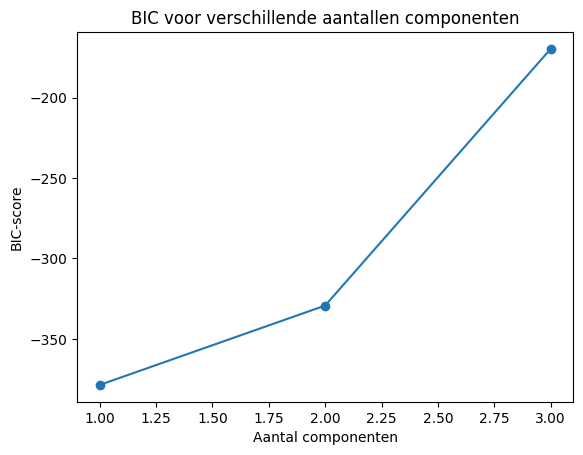

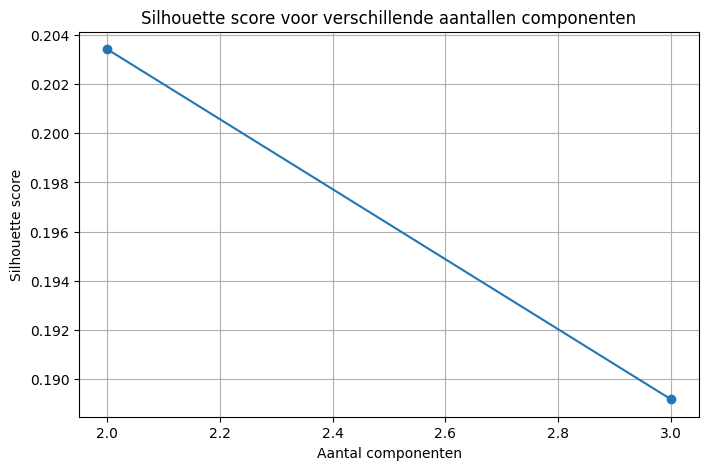

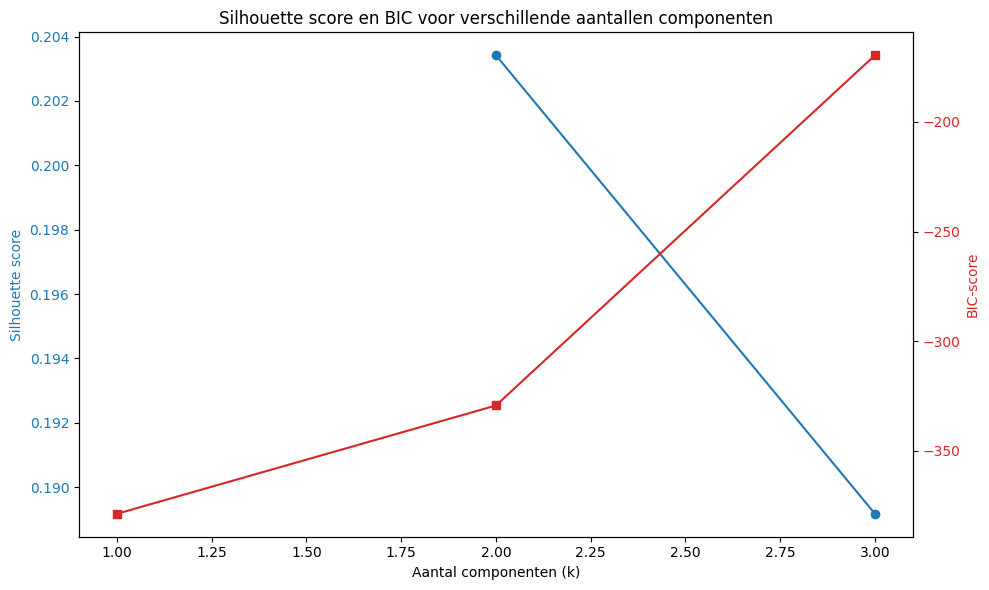

In [21]:
#Range van aantal clusters bepaeln
n_components = np.arange(1,4)

sil_scores = []
bics = []

# Fit GMMs en bereken BIC en Silhouette scores
for n in n_components:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(X_scaled)
    

    labels_sil = gmm.predict(X_scaled)

    bics.append(gmm.bic(X_scaled))
    if len(np.unique(labels_sil)) > 1:
        sil_scores.append(silhouette_score(X_scaled, labels_sil))
    else:
        sil_scores.append(np.nan)

#Het plotten van de BIC Score, deze was voor een eerdere analyse, maar door Henry afgeraden
plt.plot(n_components, bics, marker='o')
plt.title("BIC voor verschillende aantallen componenten")
plt.xlabel("Aantal componenten")
plt.ylabel("BIC-score")
plt.show()

# Plot Silhouette score
plt.figure(figsize=(8, 5))
plt.plot(n_components, sil_scores, marker='o')
plt.title("Silhouette score voor verschillende aantallen componenten")
plt.xlabel("Aantal componenten")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.show()


#Hier wordt een tweede plot gemaakt zodat deze twee scores samen gevisualiseerd kunnen worden
fig, ax1 = plt.subplots(figsize=(10, 6))

# Silhouette lijn
color = 'tab:blue'
ax1.set_xlabel('Aantal componenten (k)')
ax1.set_ylabel('Silhouette score', color=color)
ax1.plot(n_components, sil_scores, color=color, marker='o', label='Silhouette score')
ax1.tick_params(axis='y', labelcolor=color)

# Bic lijn
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('BIC-score', color=color)
ax2.plot(n_components, bics, color=color, marker='s', label='BIC-score')
ax2.tick_params(axis='y', labelcolor=color)

# Titels en layout
plt.title('Silhouette score en BIC voor verschillende aantallen componenten')
fig.tight_layout()
plt.show()

# Model Trainen

In [22]:
#Als n_components 4 vanwege de eerdere Silhoette score
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state= 42)
gmm.fit(X_scaled)

# code voor het voorspellen van de clusters
labels = gmm.predict(X_scaled)
probs = gmm.predict_proba(X_scaled)  # waarschijnlijkheden per cluster
# het bekijken van de belangrijkste meetvariabelen
print("Gemiddelden (centers):\n", gmm.means_)
print("\nCovariantiematrices:\n", gmm.covariances_)
print("\nLog-likelihood:", gmm.score(X_scaled))

Gemiddelden (centers):
 [[ 0.94491118 -0.12747733 -1.07941533  0.          0.         -1.20080679
   0.          0.         -0.5         0.          0.         -0.29368081
   0.84274983  0.84274983 -1.16119773]
 [ 0.          0.80250804  1.28843843  0.          0.          1.06478297
   0.          0.          2.          0.          0.          1.57359849
   0.33709993  0.33709993  1.2385627 ]
 [-0.56694671  0.67191723  0.98729727  0.          0.          0.85925433
   0.          0.         -0.5         0.          0.          0.45052789
  -0.16854997 -0.16854997  0.81292693]
 [-1.32287566 -1.2194706  -0.11690503  0.          0.          0.47757627
   0.          0.         -0.5         0.          0.         -1.43676476
  -1.85404962 -1.85404962  0.27090583]]

Covariantiematrices:
 [[[ 5.71429571e-01 -8.25469322e-01 -7.78805163e-02  0.00000000e+00
    0.00000000e+00 -6.75409236e-02  0.00000000e+00  0.00000000e+00
   -5.60830800e-31  0.00000000e+00  0.00000000e+00  1.54940166e-01
   

In [11]:
# De individuele silhouet score voor elk datapunt
score = silhouette_score(X_scaled, labels)
print("Silhoutte score:", score)

Silhoutte score: 0.15200443860496032


# Model testen
Hieronder staat de code van zes verschillende gebruikers:
Gezond- cluster a:
1.  Stabiel sterke speler, mogelijk geen NAH
2.  Neukeurig en efficient, maakt minder fouten dan 1
3.  Rustige doorwerker, is niet snel, maar rond de spellen wel foutloos af

NAH - cluster b:
4. Moeite om taken successvol af te ronden, en maakt veel fouten.
5. Consistenter dan 4, maar maakt nogsteeds veel fouten
6. Inefficient, staat dicht bij 4 en 5, maar maakt nog meer fouten.

Overig - tussengevalletjes:
7. Maakt veel fouten, maar rond alles af
8. 




In [23]:
#Kleine analyse van de verschillende datapunten
print(X_scaled)

[[-0.56694671  0.67191723  0.98729727  0.          0.          0.85925433
   0.          0.         -0.5         0.          0.          0.45052789
  -0.16854997 -0.16854997  0.81292693]
 [ 0.18898224  0.96451594 -0.97638909  0.          0.         -1.11145855
   0.          0.         -0.5         0.          0.         -0.49864739
   0.84274983  0.84274983 -1.2934134 ]
 [ 1.70084013 -1.2194706  -1.18244157  0.          0.         -1.29015503
   0.          0.         -0.5         0.          0.         -0.08871424
   0.84274983  0.84274983 -1.02898206]
 [-1.32287566 -1.2194706  -0.11690503  0.          0.          0.47757627
   0.          0.         -0.5         0.          0.         -1.43676476
  -1.85404962 -1.85404962  0.27090583]
 [ 0.          0.80250804  1.28843843  0.          0.          1.06478297
   0.          0.          2.          0.          0.          1.57359849
   0.33709993  0.33709993  1.2385627 ]]


## Visualiseren
Elk punt staat voor een observatie, dit is de speler \n
De kleuren geven aan bij welk cluster de speler ingedeeld wordt \n
De rode kruisjes zijn de gemiddelde posities van de centra \n

Dit wordt gemeten door de efficiency van de gebruiker

In [24]:
#Met deze tabel maken we inzichtelijk welke 
cluster_means = pd.DataFrame(gmm.means_, columns=features)
cluster_means.index = [f"Cluster {i}" for i in range(gmm.n_components)]
cluster_means.round(3)

,ratio_finished,ratio_mistakes,goal_time,goal_finished_ratio,goal_finished_ratio,list_time,list_finished_ratio,list_finished_ratio,check_time,check_finished_ratio,check_finished_ratio,learn_time,learn_finished_ratio,learn_finished_ratio,time
Cluster 0,0.945,-0.127,-1.079,0.0,0.0,-1.201,0.0,0.0,-0.5,0.0,0.0,-0.294,0.843,0.843,-1.161
Cluster 1,0.000,0.803,1.288,0.0,0.0,1.065,0.0,0.0,2.0,0.0,0.0,1.574,0.337,0.337,1.239
Cluster 2,-0.567,0.672,0.987,0.0,0.0,0.859,0.0,0.0,-0.5,0.0,0.0,0.451,-0.169,-0.169,0.813
Cluster 3,-1.323,-1.219,-0.117,0.0,0.0,0.478,0.0,0.0,-0.5,0.0,0.0,-1.437,-1.854,-1.854,0.271


# Principal Component analysis (PCA)
Hierin wordt het aantal features gereduceerd naar een kleiner aantal om het analyseerbaarder te maken.

[0.50186399 0.3799656 ]


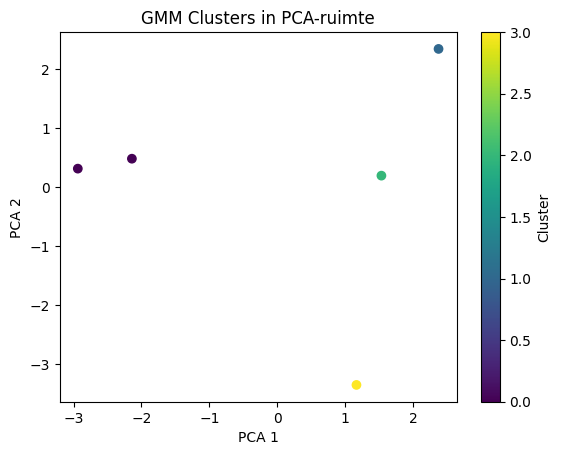

In [25]:

X = X_scaled.copy()
df_filtered = df_filtered.copy()

pca = PCA(n_components=2)


df_filtered['pca1'], df_filtered['pca2'] = pca.fit_transform(X).T
df_filtered['labels'] = labels
print (pca.explained_variance_ratio_)

plt.scatter(df_filtered['pca1'], df_filtered['pca2'], c=df_filtered['labels'], cmap='viridis')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("GMM Clusters in PCA-ruimte")
plt.colorbar(label='Cluster')
plt.show()

# Testen van model - Niet aan gekomen om enkele spelers te introduceren
De silhoutte score is een methodiek die wordt gebruikt om kwaliteit van de clusters te evalueren. Het meet ieder datapunt, en vergelijkt deze met andere

In [15]:
#Hier moet een al geaggregreerde speler in komen
print(df.index)
new_user = df.loc[df['user_id'] == 303, features].values.reshape(1, -1)
new_user_scaled = scaler.transform(new_user)

cluster = gmm.predict(new_user)
print(cluster)

RangeIndex(start=0, stop=5, step=1)


ValueError: Found array with 0 feature(s) (shape=(1, 0)) while a minimum of 1 is required by StandardScaler.

In [72]:
#Testusers voor het testen van de dataset
df_test = pd.DataFrame({
    'finished_mean': [5, -5, 0.85, -1.2, -1.1, -0.9, 0.7],
    'mistakes_mean': [5, -5, 0.2, 1.3, 1.1, 1.4, 1.4],
    'time_variability': [5, -5, 0.3, 2.2, 2.1, 3, 1.8],
    'efficiency_mean': [5, -5,0.002, -0.9, -1.0, -1.1 , -0.5]
})

#scale de data naar normaal formaat
df_test_scaled = scaler.transform(df_test)

print(df_test_scaled)
# code voor het voorspellen van de clusters
labels_test = gmm.predict(df_test_scaled)
probs_test = gmm.predict_proba(df_test_scaled)  # waarschijnlijkheden per cluster

print(df_filtered[features].describe())
print("Clusters:", labels_test)
print("\nProbabilities per gebruiker:")
print(probs_test)
print(gmm.covariances_)

C:\Users\alecv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


ValueError: X has 4 features, but StandardScaler is expecting 8 features as input.